# KNN Baseline – Data Challenge ENEDIS

Baseline KNN avec PCA pour prédire Y_train à partir de X_train.

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error


In [2]:

# Chargement des données
x_train = pd.read_csv("data/X_train_78VdSWL.csv")
y_train = pd.read_csv("data/y_train_u0UkKEh.csv")

# Conversion Horodate
x_train["Horodate"] = pd.to_datetime(x_train["Horodate"])
y_train["Horodate"] = pd.to_datetime(y_train["Horodate"])

# Vérification alignement temporel
assert (x_train["Horodate"].values == y_train["Horodate"].values).all()
print("Horodate alignée")


Horodate alignée


In [3]:

# Features temporelles
x_train["hour"] = x_train["Horodate"].dt.hour
x_train["weekday"] = x_train["Horodate"].dt.weekday
x_train["hour_sin"] = np.sin(2*np.pi*x_train["hour"]/24)
x_train["hour_cos"] = np.cos(2*np.pi*x_train["hour"]/24)

# Suppression Horodate
x_train = x_train.drop(columns=["Horodate"])
y_train = y_train.drop(columns=["Horodate"])


In [4]:

# Gestion des NaN
x_train["nb_missing"] = x_train.isnull().sum(axis=1)
x_train = x_train.fillna(0)

print(f"X shape : {x_train.shape}")
print(f"Y shape : {y_train.shape}")


X shape : (1057, 21005)
Y shape : (1057, 1000)


In [5]:

# Split temporel
split_idx = int(0.8 * len(x_train))

X_tr = x_train.iloc[:split_idx]
X_val = x_train.iloc[split_idx:]

Y_tr = y_train.iloc[:split_idx]
Y_val = y_train.iloc[split_idx:]


In [6]:

# Standardisation
scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(X_tr)
X_val_scaled = scaler.transform(X_val)


In [7]:

# PCA
pca = PCA(n_components=50, random_state=42)
X_tr_pca = pca.fit_transform(X_tr_scaled)
X_val_pca = pca.transform(X_val_scaled)

print(f"Variance expliquée : {pca.explained_variance_ratio_.sum()*100:.2f}%")


Variance expliquée : 53.41%


In [10]:
print("NaN dans Y_train :", y_train.isnull().sum().sum())
print("NaN par colonne (extrait) :")
print(y_train.isnull().mean().sort_values(ascending=False).head())


NaN dans Y_train : 1056
NaN par colonne (extrait) :
holed_192     0.999054
holed_985     0.000000
holed_984     0.000000
holed_9       0.000000
holed_1000    0.000000
dtype: float64


In [11]:
# Masque des lignes sans NaN dans Y
valid_mask = ~y_train.isnull().any(axis=1)

print(f"Lignes valides : {valid_mask.sum()} / {len(valid_mask)}")

# Filtrage
X_clean = x_train.loc[valid_mask].reset_index(drop=True)
Y_clean = y_train.loc[valid_mask].reset_index(drop=True)


Lignes valides : 1 / 1057


In [12]:
split_idx = int(0.8 * len(X_clean))

X_tr = X_clean.iloc[:split_idx]
X_val = X_clean.iloc[split_idx:]

Y_tr = Y_clean.iloc[:split_idx]
Y_val = Y_clean.iloc[split_idx:]


In [13]:

# Modèle KNN
knn = KNeighborsRegressor(n_neighbors=5, weights="distance", metric="euclidean", n_jobs=-1)
knn.fit(X_tr_pca, Y_tr)


ValueError: Found array with 0 sample(s) (shape=(0, 1000)) while a minimum of 1 is required by KNeighborsRegressor.

## Classic error above, we correct it using KNN for 1 client



In [29]:
target_col = "holed_3"   # modifiable

valid_mask = ~y_train[target_col].isnull()

print(f"Lignes valides pour {target_col} : {valid_mask.sum()} / {len(valid_mask)}")

X_client = x_train.loc[valid_mask].reset_index(drop=True)
Y_client = y_train.loc[valid_mask, target_col].reset_index(drop=True)


Lignes valides pour holed_3 : 1057 / 1057


In [30]:
split_idx = int(0.8 * len(X_client))

X_tr = X_client.iloc[:split_idx]
X_val = X_client.iloc[split_idx:]

Y_tr = Y_client.iloc[:split_idx]
Y_val = Y_client.iloc[split_idx:]


In [16]:
scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(X_tr)
X_val_scaled = scaler.transform(X_val)

pca = PCA(n_components=50, random_state=42)
X_tr_pca = pca.fit_transform(X_tr_scaled)
X_val_pca = pca.transform(X_val_scaled)

print(f"Variance expliquée : {pca.explained_variance_ratio_.sum()*100:.2f}%")


Variance expliquée : 53.41%


In [31]:
knn = KNeighborsRegressor(
    n_neighbors=5,
    weights="distance",
    metric="euclidean",
    n_jobs=-1
)

knn.fit(X_tr_pca, Y_tr)
knn = KNeighborsRegressor(
    n_neighbors=5,
    weights="distance",
    metric="euclidean",
    n_jobs=-1
)

knn.fit(X_tr_pca, Y_tr)


KNeighborsRegressor(metric='euclidean', n_jobs=-1, weights='distance')

In [32]:
from sklearn.metrics import root_mean_squared_error

rmse = root_mean_squared_error(Y_val, Y_pred)
print(f"RMSE KNN pour {target_col} : {rmse:.4f}")



RMSE KNN pour holed_3 : 859.1421


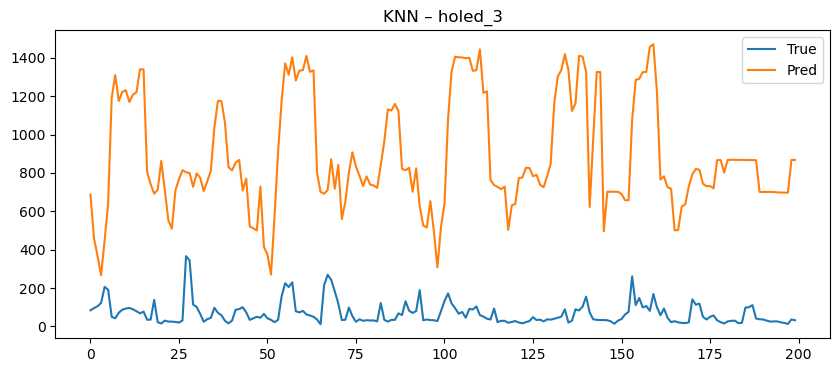

In [33]:
plt.figure(figsize=(10,4))
plt.plot(Y_val.iloc[:200].values, label="True")
plt.plot(Y_pred[:200], label="Pred")
plt.legend()
plt.title(f"KNN – {target_col}")
plt.show()
